In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import seaborn as sns
import nheatmap
from time import time
from pathlib import Path
import gzip
import json
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import umap
import re

import lifelines
# from lifelines import KaplanMeierFitter

from time import time

from stat_tools import Benjamini_Hochberg

from importlib import reload

import heatmap_grouped
from heatmap_grouped import heatmap_grouped as hg


/Users/emarti/.virtualenvs/siglec/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mpl.rcParams['figure.figsize'] = [4, 3]
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['font.size'] = 8
mpl.rcParams['lines.linewidth'] = 1.
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

In [4]:
data_path = Path('../pcawg/pcawg_data1/')
data_path_broad = Path('../pcawg/broad/')
cbioportal_clinical_file = data_path / '..' / 'cbioportal' / 'prad_tcga_clinical_data.tsv'
significant_genes_file = Path('results') / 'significant genes-correlation analysis.txt'

In [5]:
savefigs = True

# Load prostate tumor data from the PRAD-US project in PCAWG

Data source 1: https://dcc.icgc.org/releases/current/Projects/PRAD-CA
Data source 2: http://firebrowse.org/?cohort=PRAD&download_dialog=true

In [6]:

df_expression = pd.read_table(data_path_broad / 'PRAD.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.txt', skiprows=[1])

df_expression['gene_id'] = df_expression.iloc[:,0].str.split('|').str[0]
df_expression.drop(columns="Hybridization REF", inplace=True)
df_expression = df_expression.loc[df_expression['gene_id'] != '?']

# Only one gene is duplicated. Drop it.
print("Duplicate genes:", df_expression.loc[df_expression['gene_id'].duplicated(), 'gene_id'])
df_expression = df_expression.loc[~df_expression['gene_id'].duplicated()]
df_expression.set_index('gene_id', inplace=True)

# Unstack
df_expression = df_expression.unstack().reset_index().rename(columns={'level_0':'sample', 0:'expression'})


# Add specimen and donor names and types
myre_donor = re.compile(r'TCGA-\w{2}-\w{4}')
myre_specimen = re.compile(r'TCGA-\w{2}-\w{4}-\w{3}')
df_expression['submitted_donor_id'] = df_expression['sample'].apply(lambda x: myre_donor.match(x)[0])
df_expression['submitted_specimen_id'] = df_expression['sample'].apply(lambda x: myre_specimen.match(x)[0])

# Normalize by counts per million
df_expression['tpm_read_count'] = df_expression.groupby('submitted_specimen_id')['expression'].transform(lambda x: 1e6*x/x.sum())
df_expression['log_tpm_read_count'] = np.log10(1+df_expression['tpm_read_count'])



Duplicate genes: 16301    SLC35E2
Name: gene_id, dtype: object


# Load the type of specimen: we want to compare tumor with normal-adjacent-to-tumor

In [7]:
df_specimen = pd.read_table(data_path / 'specimen.PRAD-US.tsv.gz')
df_specimen.head()

,icgc_specimen_id,project_code,study_specimen_involved_in,submitted_specimen_id,icgc_donor_id,submitted_donor_id,specimen_type,specimen_type_other,specimen_interval,specimen_donor_treatment_type,...,tumour_histological_type,tumour_grading_system,tumour_grade,tumour_grade_supplemental,tumour_stage_system,tumour_stage,tumour_stage_supplemental,digital_image_of_stained_section,percentage_cellularity,level_of_cellularity
0,SP80146,PRAD-US,NaN,TCGA-EJ-7797-01A,DO36329,TCGA-EJ-7797,Primary tumour - solid tissue,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://REPLACE_WITH_REAL_URL/2864bcdb-667d-4ae...,NaN,NaN
1,SP80145,PRAD-US,NaN,TCGA-EJ-7797-10A,DO36329,TCGA-EJ-7797,Normal - blood derived,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SP80147,PRAD-US,NaN,TCGA-EJ-7797-11A,DO36329,TCGA-EJ-7797,Normal - tissue adjacent to primary,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://REPLACE_WITH_REAL_URL/5a618e32-b874-4d4...,NaN,NaN
3,SP80141,PRAD-US,NaN,TCGA-CH-5743-10A,DO36327,TCGA-CH-5743,Normal - blood derived,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SP80142,PRAD-US,NaN,TCGA-CH-5743-01A,DO36327,TCGA-CH-5743,Primary tumour - solid tissue,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://REPLACE_WITH_REAL_URL/bdd72a99-8608-45a...,NaN,NaN


In [8]:
df_donor_icgc = pd.read_table(data_path / 'donor.PRAD-US.tsv.gz')
df_donor_icgc.head()

,icgc_donor_id,project_code,study_donor_involved_in,submitted_donor_id,donor_sex,donor_vital_status,disease_status_last_followup,donor_relapse_type,donor_age_at_diagnosis,donor_age_at_enrollment,...,donor_relapse_interval,donor_diagnosis_icd10,donor_tumour_staging_system_at_diagnosis,donor_tumour_stage_at_diagnosis,donor_tumour_stage_at_diagnosis_supplemental,donor_survival_time,donor_interval_of_last_followup,prior_malignancy,cancer_type_prior_malignancy,cancer_history_first_degree_relative
0,DO36329,PRAD-US,NaN,TCGA-EJ-7797,male,alive,complete remission,NaN,53,NaN,...,NaN,C61,NaN,NaN,NaN,NaN,187.0,unknown,NaN,unknown
1,DO36327,PRAD-US,NaN,TCGA-CH-5743,male,alive,complete remission,NaN,66,NaN,...,NaN,C61,NaN,NaN,NaN,NaN,425.0,unknown,NaN,unknown
2,DO36328,PRAD-US,NaN,TCGA-G9-6361,male,alive,complete remission,NaN,61,NaN,...,NaN,C61,NaN,NaN,NaN,NaN,1008.0,unknown,NaN,unknown
3,DO36325,PRAD-US,NaN,TCGA-G9-6351,male,alive,complete remission,NaN,51,NaN,...,NaN,C61,NaN,NaN,NaN,NaN,1215.0,unknown,NaN,unknown
4,DO36326,PRAD-US,NaN,TCGA-EJ-7125,male,alive,complete remission,NaN,44,NaN,...,NaN,C61,NaN,NaN,NaN,NaN,1860.0,unknown,NaN,unknown


In [9]:
# Download clinical data from cBioPortal: https://www.cbioportal.org/study/clinicalData?id=prad_tcga
# I saved the file as "prad_tcga_clinical_data.tsv"

df_donor_cbioportal = pd.read_table(cbioportal_clinical_file)

In [10]:
df_donor = df_donor_icgc.merge(right=df_donor_cbioportal[['Patient ID', 'Disease Free (Months)', 'Disease Free Status']],
                           left_on='submitted_donor_id',
                           right_on='Patient ID',
                           how='inner')
print(len(df_donor['icgc_donor_id'].unique()))
print(df_donor['Disease Free Status'].unique())
print(sum(df_donor['Disease Free Status'].dropna().str.startswith('1')))
print(sum(df_donor['Disease Free Status'].dropna().str.startswith('0')))


500
['0:DiseaseFree' '1:Recurred/Progressed' nan]
92
403


In [11]:
# Merge specimen data with expressions

df = pd.merge(df_expression,
         df_specimen[['submitted_specimen_id', 'specimen_type']],
         how='left',
         on='submitted_specimen_id')

df = df.loc[df['specimen_type'].isin(['Primary tumour - solid tissue',
       'Normal - tissue adjacent to primary'])]

# Only keep normal and primary tumor.

df['specimen_type'].unique()

array(['Primary tumour - solid tissue',
       'Normal - tissue adjacent to primary'], dtype=object)

In [12]:
df.columns

Index(['sample', 'gene_id', 'expression', 'submitted_donor_id',
       'submitted_specimen_id', 'tpm_read_count', 'log_tpm_read_count',
       'specimen_type'],
      dtype='object')

In [13]:
print('Number of donors:', df['submitted_donor_id'].nunique())
print('Number of specimens:', df['submitted_specimen_id'].nunique())
print('Number of specimens:', df.loc[df['specimen_type']=='Normal - tissue adjacent to primary', 'submitted_specimen_id'].nunique())
print('Number of specimens:', df.loc[df['specimen_type']=='Primary tumour - solid tissue', 'submitted_specimen_id'].nunique())

Number of donors: 497
Number of specimens: 549
Number of specimens: 52
Number of specimens: 497


# Load genes associated with glycosylation

In [14]:
# all_genes = df['gene_id'].drop_duplicates().tolist()

# Load GO

In [15]:
GO_FILE = 'go/go.json.gz'

with gzip.open(GO_FILE, 'rt', encoding="ascii") as f:
    # print(f[:10])
    go_terms = json.loads(f.read())
    path_name_to_gene = go_terms['path_name_to_gene']
    
    

In [16]:
list(path_name_to_gene.keys())[:5]

['Molecular_function (GO MF)',
 'Rna binding (GO MF)',
 'Organic cyclic compound binding (GO MF)',
 'Binding (GO MF)',
 'Nucleic acid binding (GO MF)']

# Load immune pathways

In [17]:
[x for x in path_name_to_gene.keys() if x.startswith('Molecular transducer')]

['Molecular transducer activity (GO MF)']

In [18]:

pathways = {
            # 'Cell cycle': 'Cell cycle (GO BP)',
            # 'Regulation of\nimmune response': 'Regulation of immune response (GO BP)',
            # 'Extracellular matrix\norganization': 'Extracellular matrix organization (GO BP)',
            # 'Negative regulation of\nchemokine production': 'Negative regulation of chemokine production (GO BP)',
            # 'Type I interferon\nsignaling': 'Type i interferon-mediated signaling pathway (GO BP)',
            # 'Kinase activity': 'Kinase activity (GO MF)',
            # 'Cytokine activity': 'Cytokine activity (GO MF)',
            # 'Protein translation': 'Translation (GO BP)',
            # 'Neutrophil degranulation': 'Neutrophil degranulation (GO BP)',
            # 'Redox process': 'Oxidoreductase activity (GO MF)',
            # 'Antigen processing\nand presentation': 'Antigen processing and presentation (GO BP)',
            # 'Autophagy': 'Autophagy (GO BP)',
            'Signaling receptor activity': 'Signaling receptor activity (GO MF)',
            'Molecular transducer activity': 'Molecular transducer activity (GO MF)',
            'Immune system process': 'Immune system process (GO BP)',
            'Lymphocyte activation': 'Lymphocyte activation (GO BP)',
            'Leukocyte activation': 'Leukocyte activation (GO BP)',
            'T cell activation': 'T cell activation (GO BP)',
           }

for key, val in pathways.items():
    if val not in path_name_to_gene:
        print(key + 'NOT IN PATHWAY')
    else:
        print(key, len(path_name_to_gene[val]))
        #, len(set(genes).intersection(path_name_to_gene[val])))


Signaling receptor activity 1546
Molecular transducer activity 1546
Immune system process 2793
Lymphocyte activation 787
Leukocyte activation 949
T cell activation 561


# Plotting

In [19]:
# Remove genes with no reads
valid_genes = df.groupby('gene_id')['tpm_read_count'].any()
valid_genes = valid_genes[valid_genes].index.to_list()
if '?' in valid_genes:
    valid_genes.remove('?')
df = df[df['gene_id'].isin(valid_genes)].copy()


# Normalize
df['log_tpm_read_count'] = np.log10(1+df['tpm_read_count'])
# df_select_genes = df.loc[df['gene_id'].isin(sialic_genes)]




## Heatmap of sialic-acid enzyme expression vs immune genes from Stanczak, et al. 2022

In [20]:
# In R
# Load 'TCGAdata.RData'
# 
# Run:
# > write.csv(unique(IMM$gene_name), file = 'immune_genes.csv', row.names = FALSE)
# > write.csv(unique(SIAL$gene_name), file = 'sialic_acid_genes.csv', row.names = FALSE)

In [21]:
immune_genes = pd.read_table('gene lists/immune_genes.csv')['x'].to_list()
sialic_genes = pd.read_table('gene lists/sialic_acid_genes.csv')['x'].to_list()
sialic_genes.remove('C20orf173')
print(len(immune_genes))

# Exclude immune genes that overlap. There are four
print((set(immune_genes).intersection(sialic_genes)))
print("Overlapping sialic and immune genes", len(set(immune_genes).intersection(sialic_genes)))
immune_genes = list(set(immune_genes).difference(sialic_genes))
print(len(immune_genes))
print(set(immune_genes).intersection(sialic_genes))
print(len(sialic_genes))

531
{'ST3GAL6', 'ST6GALNAC4', 'NPL', 'ST8SIA1'}
Overlapping sialic and immune genes 4
527
set()
33


In [22]:
start = time()
df_immune_vs_sialic = df.loc[df['gene_id'].isin(set(immune_genes+sialic_genes))]

print(time() - start)

0.34094715118408203


In [23]:
len(set(df_immune_vs_sialic['gene_id'].tolist()).intersection(immune_genes))

497

In [24]:
len(set(immune_genes).difference(df_immune_vs_sialic['gene_id'].tolist()))

30

In [25]:
# WARNING: MANY GENES HAVE MULTIPLE ENTIRES IN THE TCGA FILE
# I don't know why

pivot_table = pd.pivot_table(
    df_immune_vs_sialic,
    index='gene_id',
    columns='submitted_specimen_id',
    values='log_tpm_read_count')

corr_matrix = pivot_table.T.corr(method='pearson')

# I only want the cross correlation terms
corr_matrix = \
    corr_matrix.loc[list(set(immune_genes).intersection(pivot_table.index)),
                    list(set(sialic_genes).intersection(pivot_table.index))]

/Users/emarti/.virtualenvs/siglec/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/emarti/.virtualenvs/siglec/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


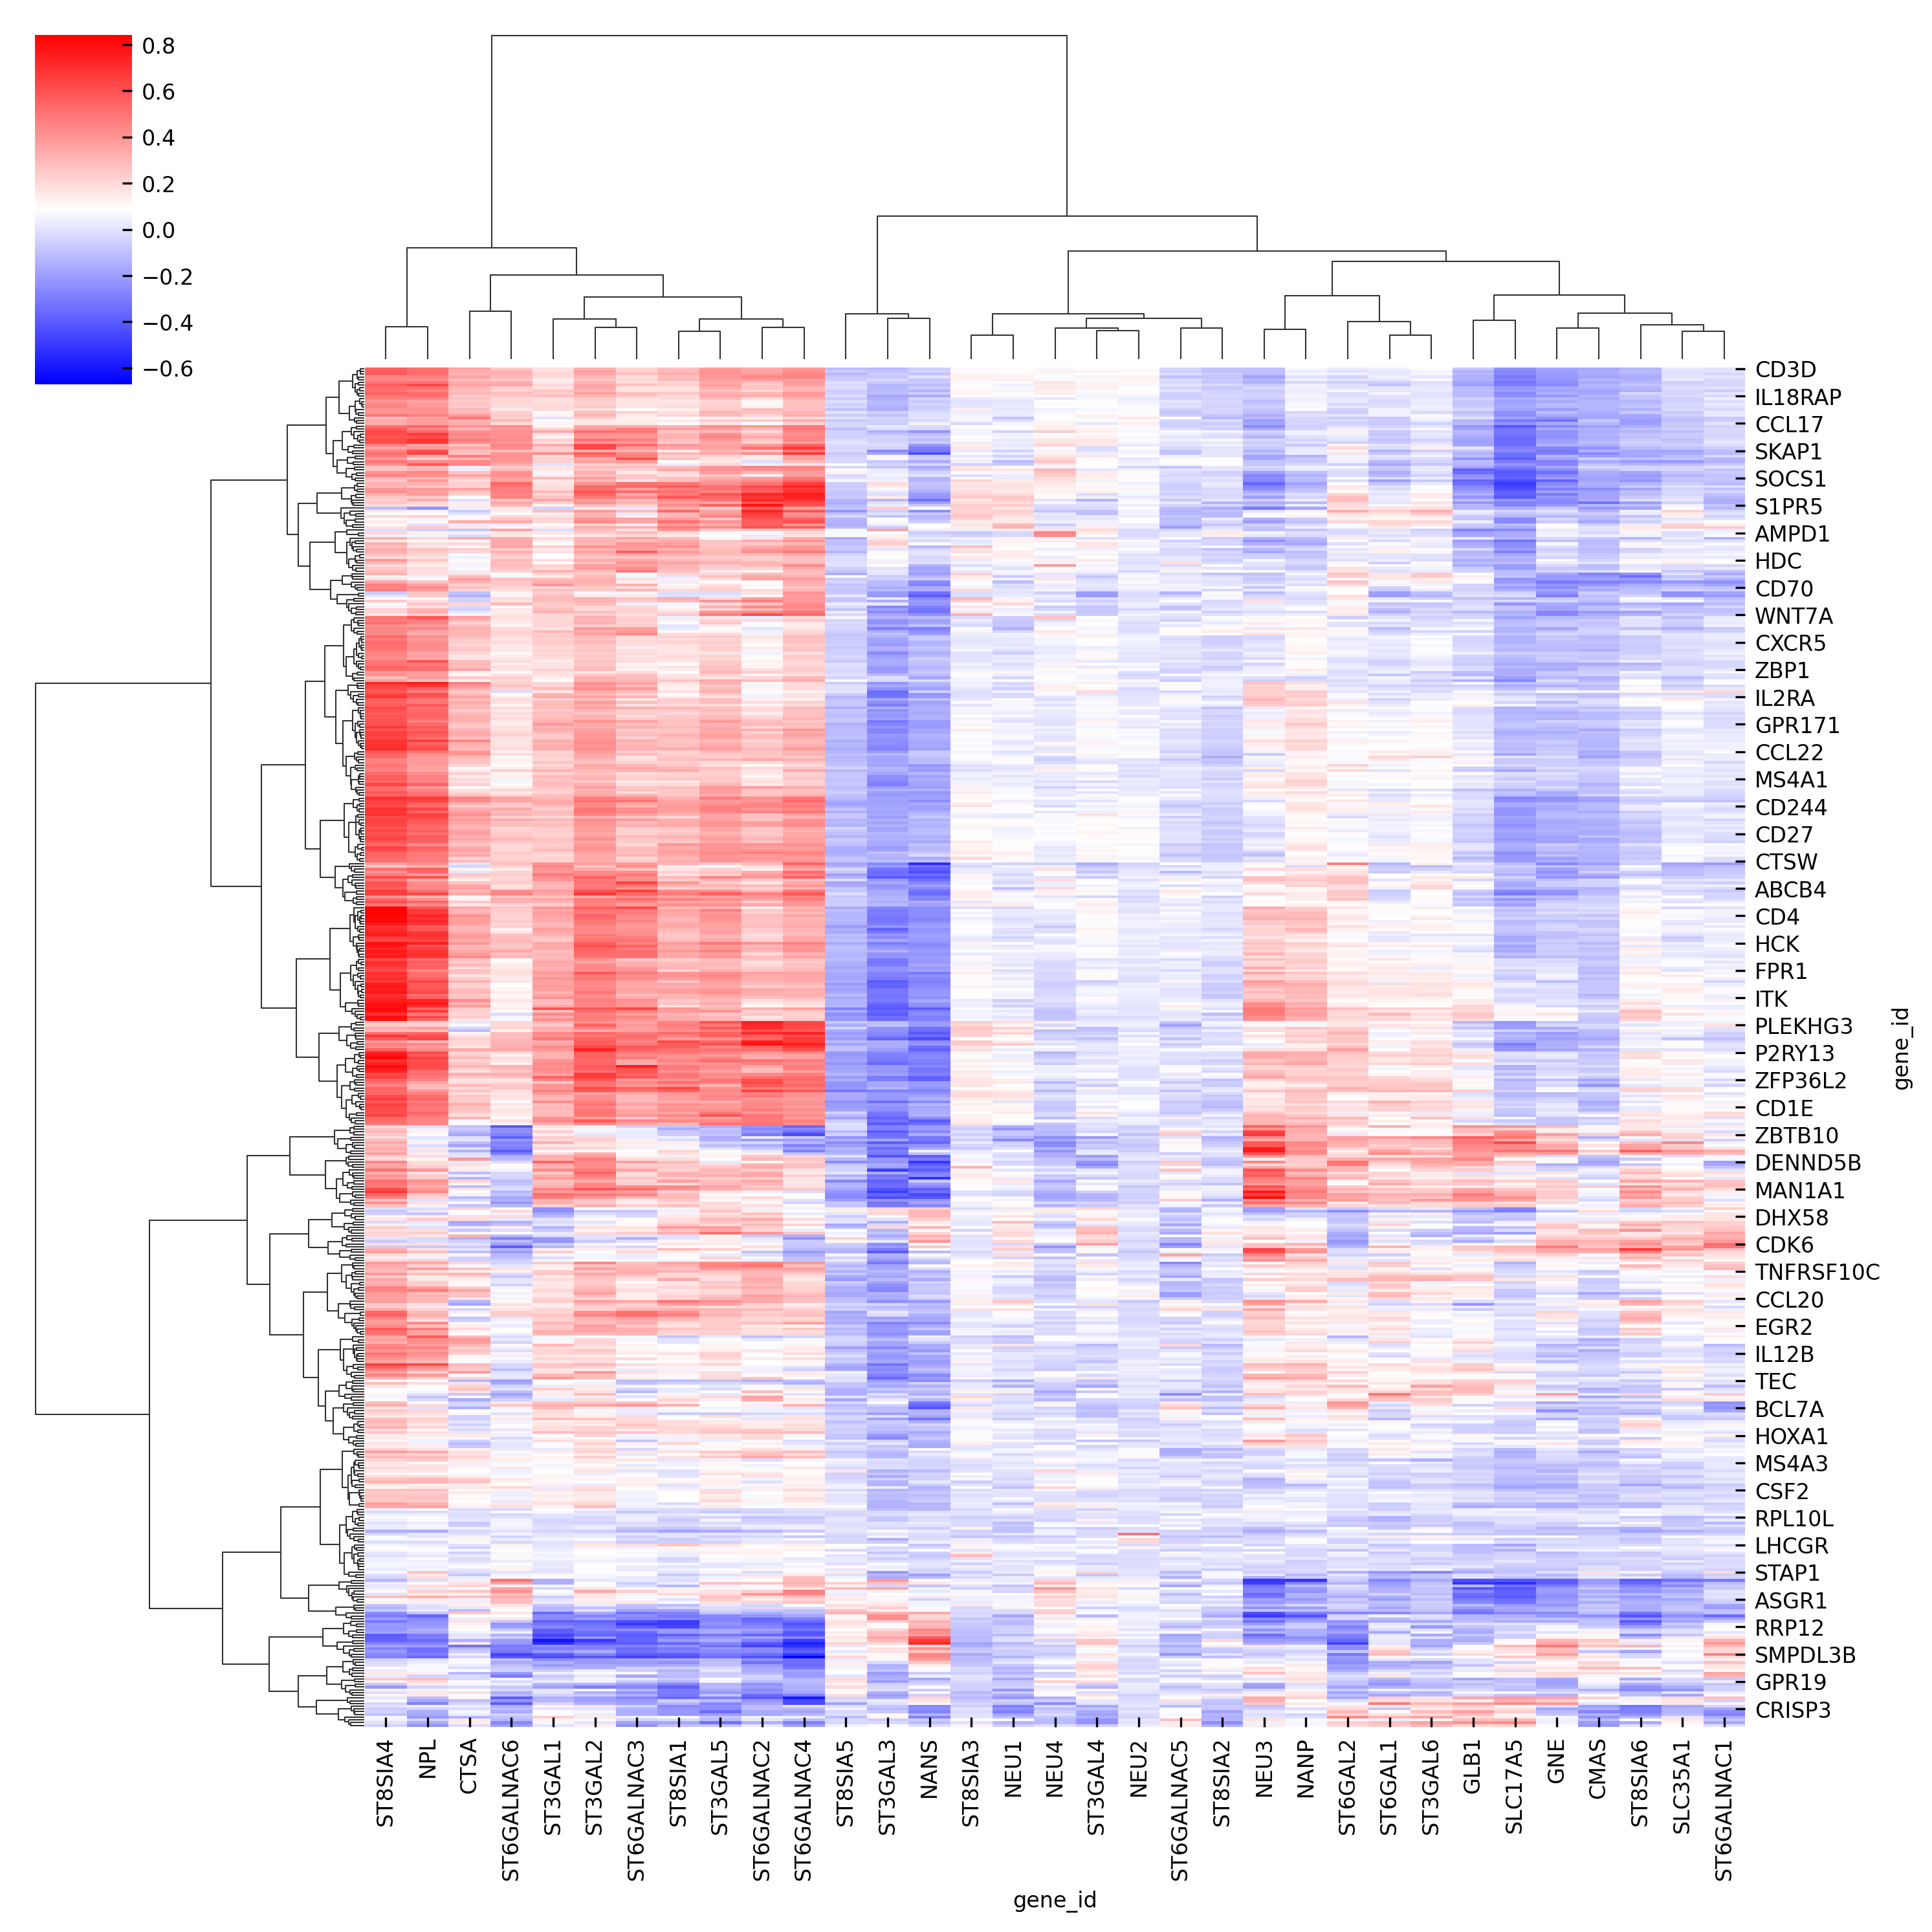

In [26]:
cluster_grid = sns.clustermap(corr_matrix, cmap='bwr', z_score=None, method='ward')
if savefigs:
    cluster_grid.savefig('figures/correlation_sialic_immune.png')


# Cluster sialic-acid enzyme genes by their correlations with immune genes

In [27]:
n_clusters = 3

X = corr_matrix.T.to_numpy()
cluster_agg = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit_predict(X)

pca_ = PCA(whiten=False).fit_transform(X)
cluster_kmeans = KMeans(n_clusters=n_clusters).fit_predict(pca_)

#cluster_genes = [ corr_matrix.columns[cluster_kmeans==i].tolist() for i in range(n_clusters) ] 

/Users/emarti/.virtualenvs/siglec/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


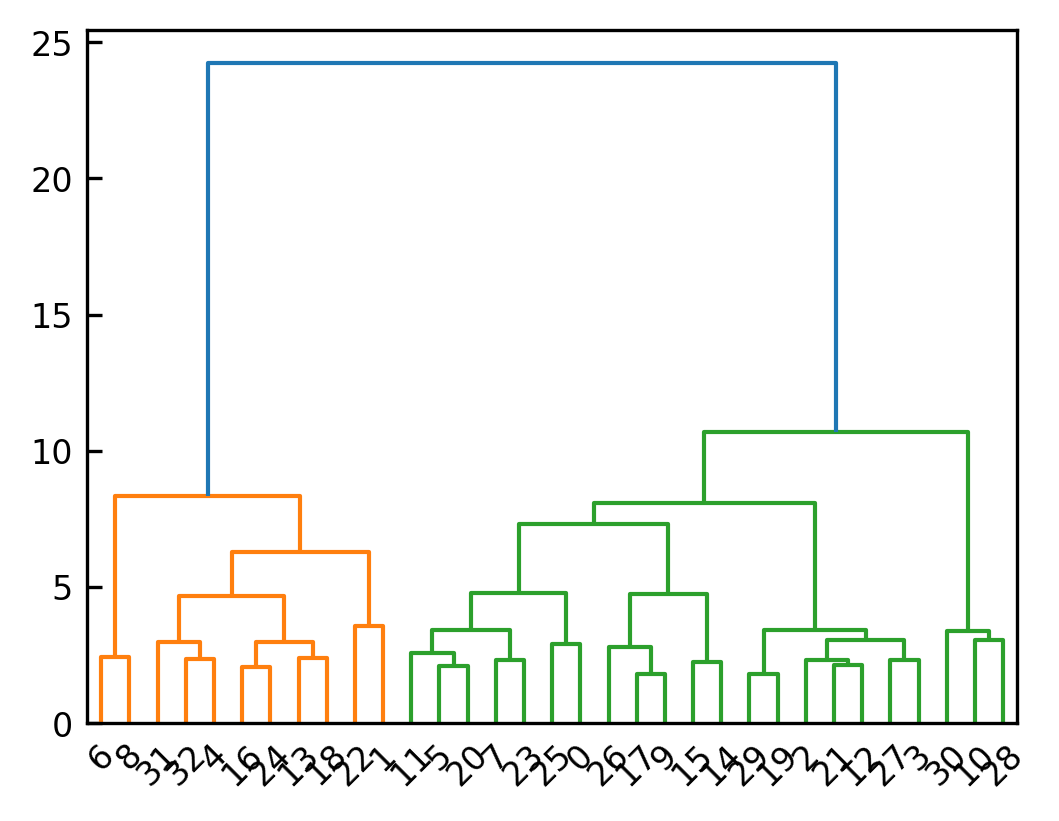

In [28]:
# Use scipy hierarchical for the ordering
sialic_linkage = sp.cluster.hierarchy.linkage(X, method='ward', optimal_ordering=True)
cluster_hier = sp.cluster.hierarchy.fcluster(sialic_linkage, t=3, criterion='maxclust') - 1
cluster_hier_index = sp.cluster.hierarchy.leaves_list(sialic_linkage)
sp.cluster.hierarchy.dendrogram(sialic_linkage);

genes_ordered = corr_matrix.columns[cluster_hier_index]
clusters_ordered = cluster_hier[cluster_hier_index]

cluster_genes = [ genes_ordered[clusters_ordered==i]
                 for i in range(n_clusters) ]



In [29]:
np.allclose(cluster_hier_index, cluster_grid.dendrogram_col.reordered_ind)

False

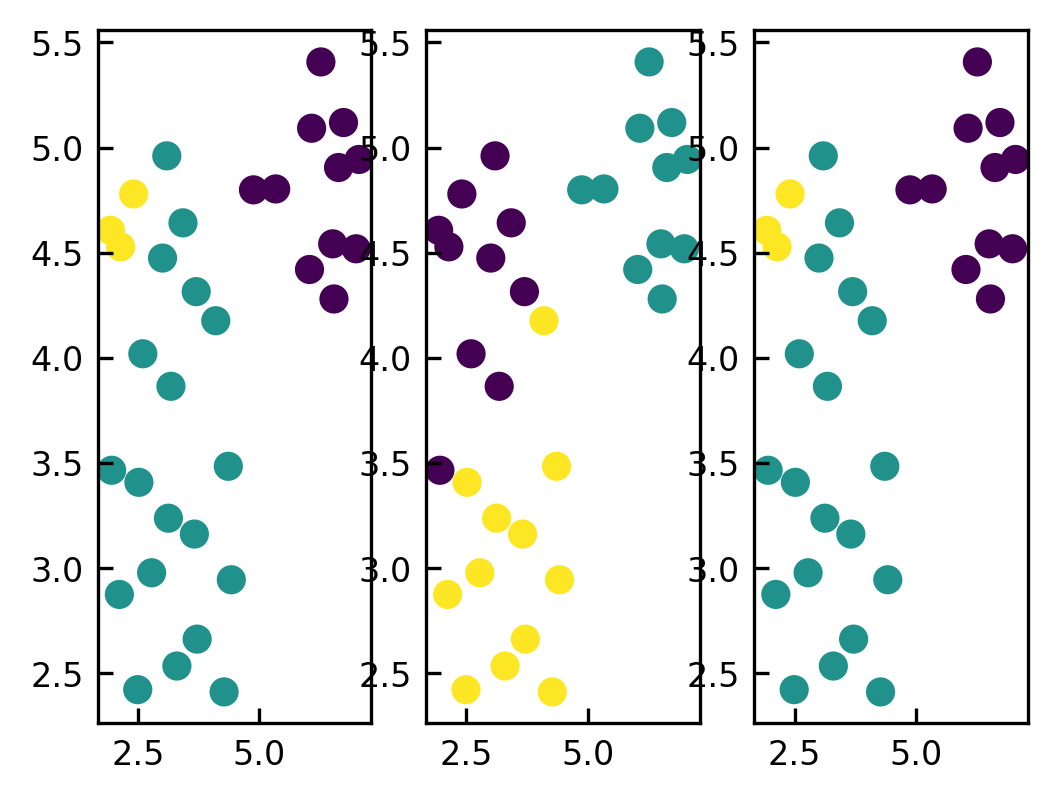

In [30]:
# UMAP or kmeans gives the same results
umap_ = umap.UMAP().fit_transform(X)
fig, ax = plt.subplots(1, 3)
ax[0].scatter(umap_[:,0], umap_[:,1], c=cluster_agg)

ax[1].scatter(umap_[:,0], umap_[:,1], c=cluster_kmeans)

ax[2].scatter(umap_[:,0], umap_[:,1], c=cluster_hier)

In [31]:
sp.__version__

'1.11.4'

In [32]:
print(confusion_matrix(cluster_agg, cluster_kmeans))
print(confusion_matrix(cluster_agg, cluster_hier))
print(confusion_matrix(cluster_kmeans, cluster_hier))

[[ 0 11  0]
 [ 7  0 12]
 [ 3  0  0]]
[[11  0  0]
 [ 0 19  0]
 [ 0  0  3]]
[[ 0  7  3]
 [11  0  0]
 [ 0 12  0]]


# Survival analysis or hazard ratio

In this paper (https://www.science.org/doi/10.1126/scitranslmed.abj1270), they average gene expression and separate by quantile

In [33]:
df_clustered_expression = []

df_ = df.loc[(df['gene_id'].isin(sialic_genes))
             &(df['specimen_type']=='Primary tumour - solid tissue')]
for i, genes in enumerate(cluster_genes):
    # z-score each gene, then average the values?
    pt = pd.pivot_table(df_.loc[(df_['gene_id'].isin(genes))],
                        values='log_tpm_read_count',
                        columns='gene_id',
                        index='submitted_donor_id')
    z = (pt-pt.mean())/pt.std()

    df2 = z.mean(axis=1).to_frame('log_tpm_read_count')
    df2['cluster'] = i

    # Split by quartile
    quartile = df2['log_tpm_read_count'].quantile([0, 0.25, 0.5, 0.75, 1.0])

    df2['quartile'] = pd.cut(df2['log_tpm_read_count'], bins=quartile, labels=[0, 1, 2, 3], include_lowest=True)
    print(quartile)
    df_clustered_expression.append(df2)
df_clustered_expression = pd.concat(df_clustered_expression)

# Merge in disease state
df_clustered_expression = \
    df_clustered_expression.merge(df_donor[['submitted_donor_id','Disease Free (Months)', 'Disease Free Status']].dropna(),
        left_index=True,
        right_on='submitted_donor_id',
        how='inner')


df_clustered_expression

0.00   -1.616397
0.25   -0.442888
0.50    0.059822
0.75    0.436612
1.00    2.308020
Name: log_tpm_read_count, dtype: float64
0.00   -1.468368
0.25   -0.165026
0.50    0.048557
0.75    0.222586
1.00    0.744775
Name: log_tpm_read_count, dtype: float64
0.00   -2.532864
0.25   -0.400537
0.50   -0.036980
0.75    0.356773
1.00    2.820200
Name: log_tpm_read_count, dtype: float64


,log_tpm_read_count,cluster,quartile,submitted_donor_id,Disease Free (Months),Disease Free Status
385,-0.640890,0,0,TCGA-2A-A8VL,20.40,0:DiseaseFree
385,0.204790,1,2,TCGA-2A-A8VL,20.40,0:DiseaseFree
385,0.226263,2,2,TCGA-2A-A8VL,20.40,0:DiseaseFree
386,-0.563710,0,0,TCGA-2A-A8VO,55.88,0:DiseaseFree
386,0.097262,1,2,TCGA-2A-A8VO,55.88,0:DiseaseFree
...,...,...,...,...,...,...
235,-0.140120,1,1,TCGA-ZG-A9ND,13.47,0:DiseaseFree
235,0.669169,2,3,TCGA-ZG-A9ND,13.47,0:DiseaseFree
476,0.674877,0,3,TCGA-ZG-A9NI,4.34,0:DiseaseFree
476,-0.232881,1,0,TCGA-ZG-A9NI,4.34,0:DiseaseFree


In [34]:
df_clustered_expression.loc[pd.isna(df_clustered_expression['quartile'])]

,log_tpm_read_count,cluster,quartile,submitted_donor_id,Disease Free (Months),Disease Free Status


(0.0, 173.3025)

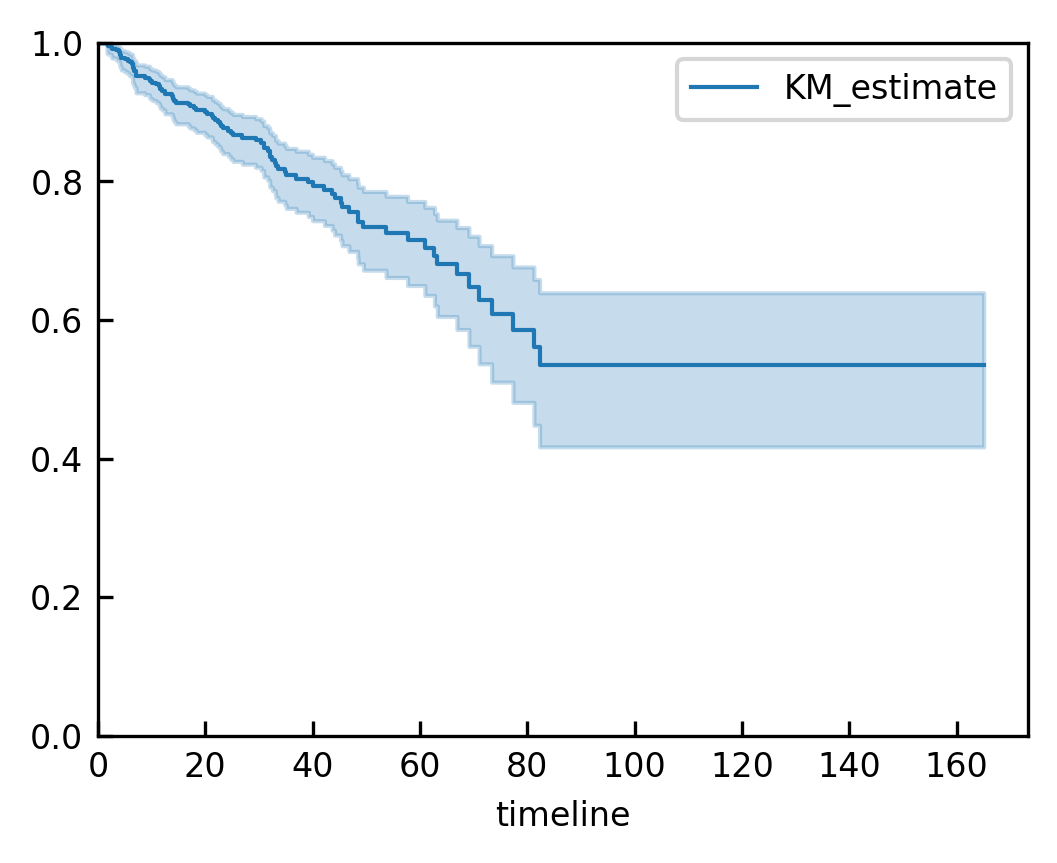

In [35]:
kmf = lifelines.KaplanMeierFitter()
df_ = df_donor[['Disease Free (Months)', 'Disease Free Status']].dropna()
kmf.fit(df_['Disease Free (Months)'], df_['Disease Free Status']=='1:Recurred/Progressed')
kmf.plot_survival_function()
plt.ylim(0, 1)
plt.xlim(left=0)

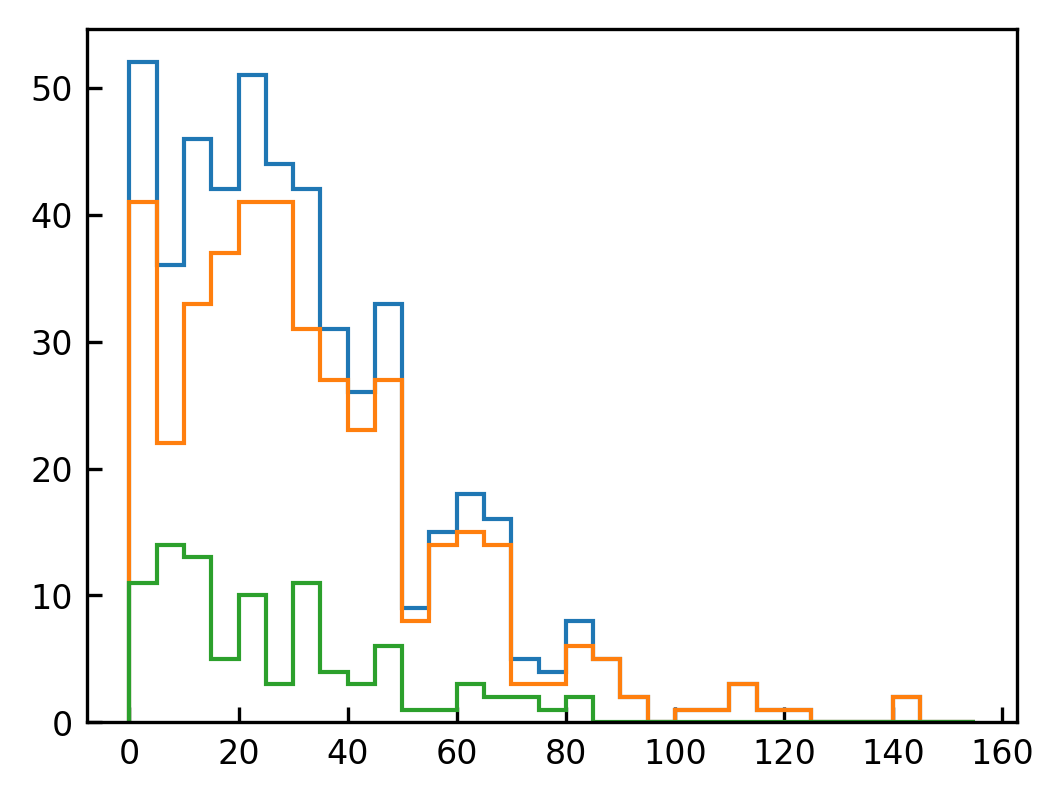

In [36]:
bins = np.arange(0, 160, 5)
plt.hist(df_donor['Disease Free (Months)'], label='all',
         bins=bins,
         histtype='step')

plt.hist(df_donor.loc[df_donor['Disease Free Status']=='0:DiseaseFree',
                      'Disease Free (Months)'], label='recurred/progressed',
         bins=bins,
         histtype='step')
plt.hist(df_donor.loc[df_donor['Disease Free Status']=='1:Recurred/Progressed',
                      'Disease Free (Months)'], label='recurred/progressed',
         bins=bins,
         histtype='step');

### Not much is showing up on Kaplan-Meier analysis.

Cluster 0 covariate
quartile    0.117039
Name: p, dtype: float64
Cluster 1 covariate
quartile    0.002131
Name: p, dtype: float64
Cluster 2 covariate
quartile    0.431335
Name: p, dtype: float64


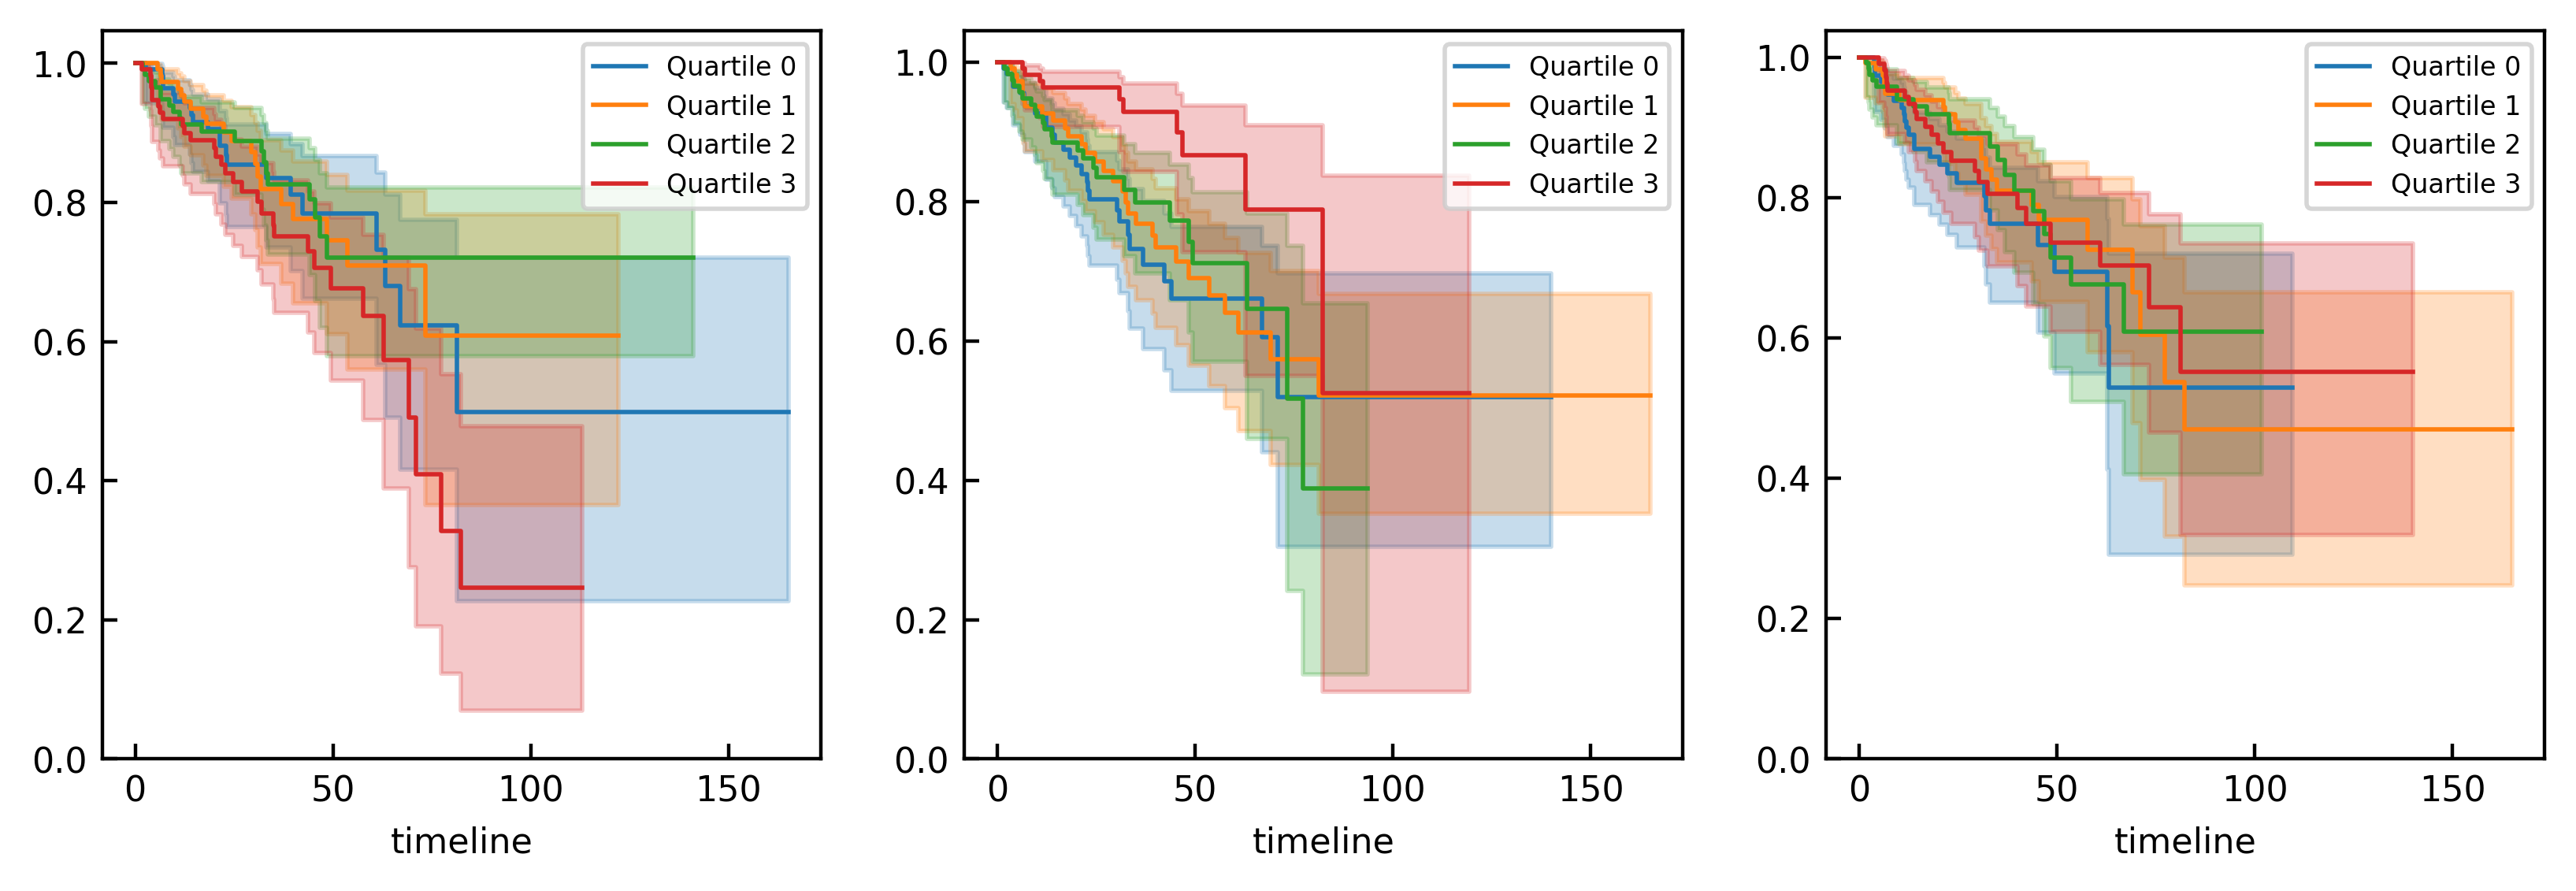

In [37]:
fig, ax = plt.subplots(1, n_clusters, figsize=(10, 3), dpi=200)
for i in range(n_clusters):
    for quartile in range(4):
        kmf = lifelines.KaplanMeierFitter()
        df_ = df_clustered_expression\
            .loc[(df_clustered_expression['cluster']==i)
                 &(df_clustered_expression['quartile']==quartile)].copy()

        kmf.fit(df_['Disease Free (Months)'], (df_['Disease Free Status']=='1:Recurred/Progressed'))
        kmf.plot_survival_function(ax=ax[i], label='Quartile {}'.format(quartile))
    ax[i].set_ylim(bottom=0)
    ax[i].legend(fontsize=6)

    # Do Cox hazard ratio test of top and bottom quartile
    df_cox = df_clustered_expression\
             .loc[(df_clustered_expression['cluster']==i)
                  &(df_clustered_expression['quartile'].isin([0, 3])),
                  ['Disease Free (Months)', 'Disease Free Status', 'quartile']].copy()
    df_cox['event'] = (df_cox.loc[:,'Disease Free Status']=='1:Recurred/Progressed').astype(int)
    df_cox.drop('Disease Free Status', axis=1, inplace=True)
    cph = lifelines.CoxPHFitter()
    cph.fit(df_cox, 'Disease Free (Months)', 'event')
    print(f'Cluster {i}', cph.summary['p'])

# Now that we have identified clusters, let's do an enrichment analysis on the immune genes that are most differentially expressed

It's my humble opinion that a gene with the largest effect size is more interesting than the smallest p-value


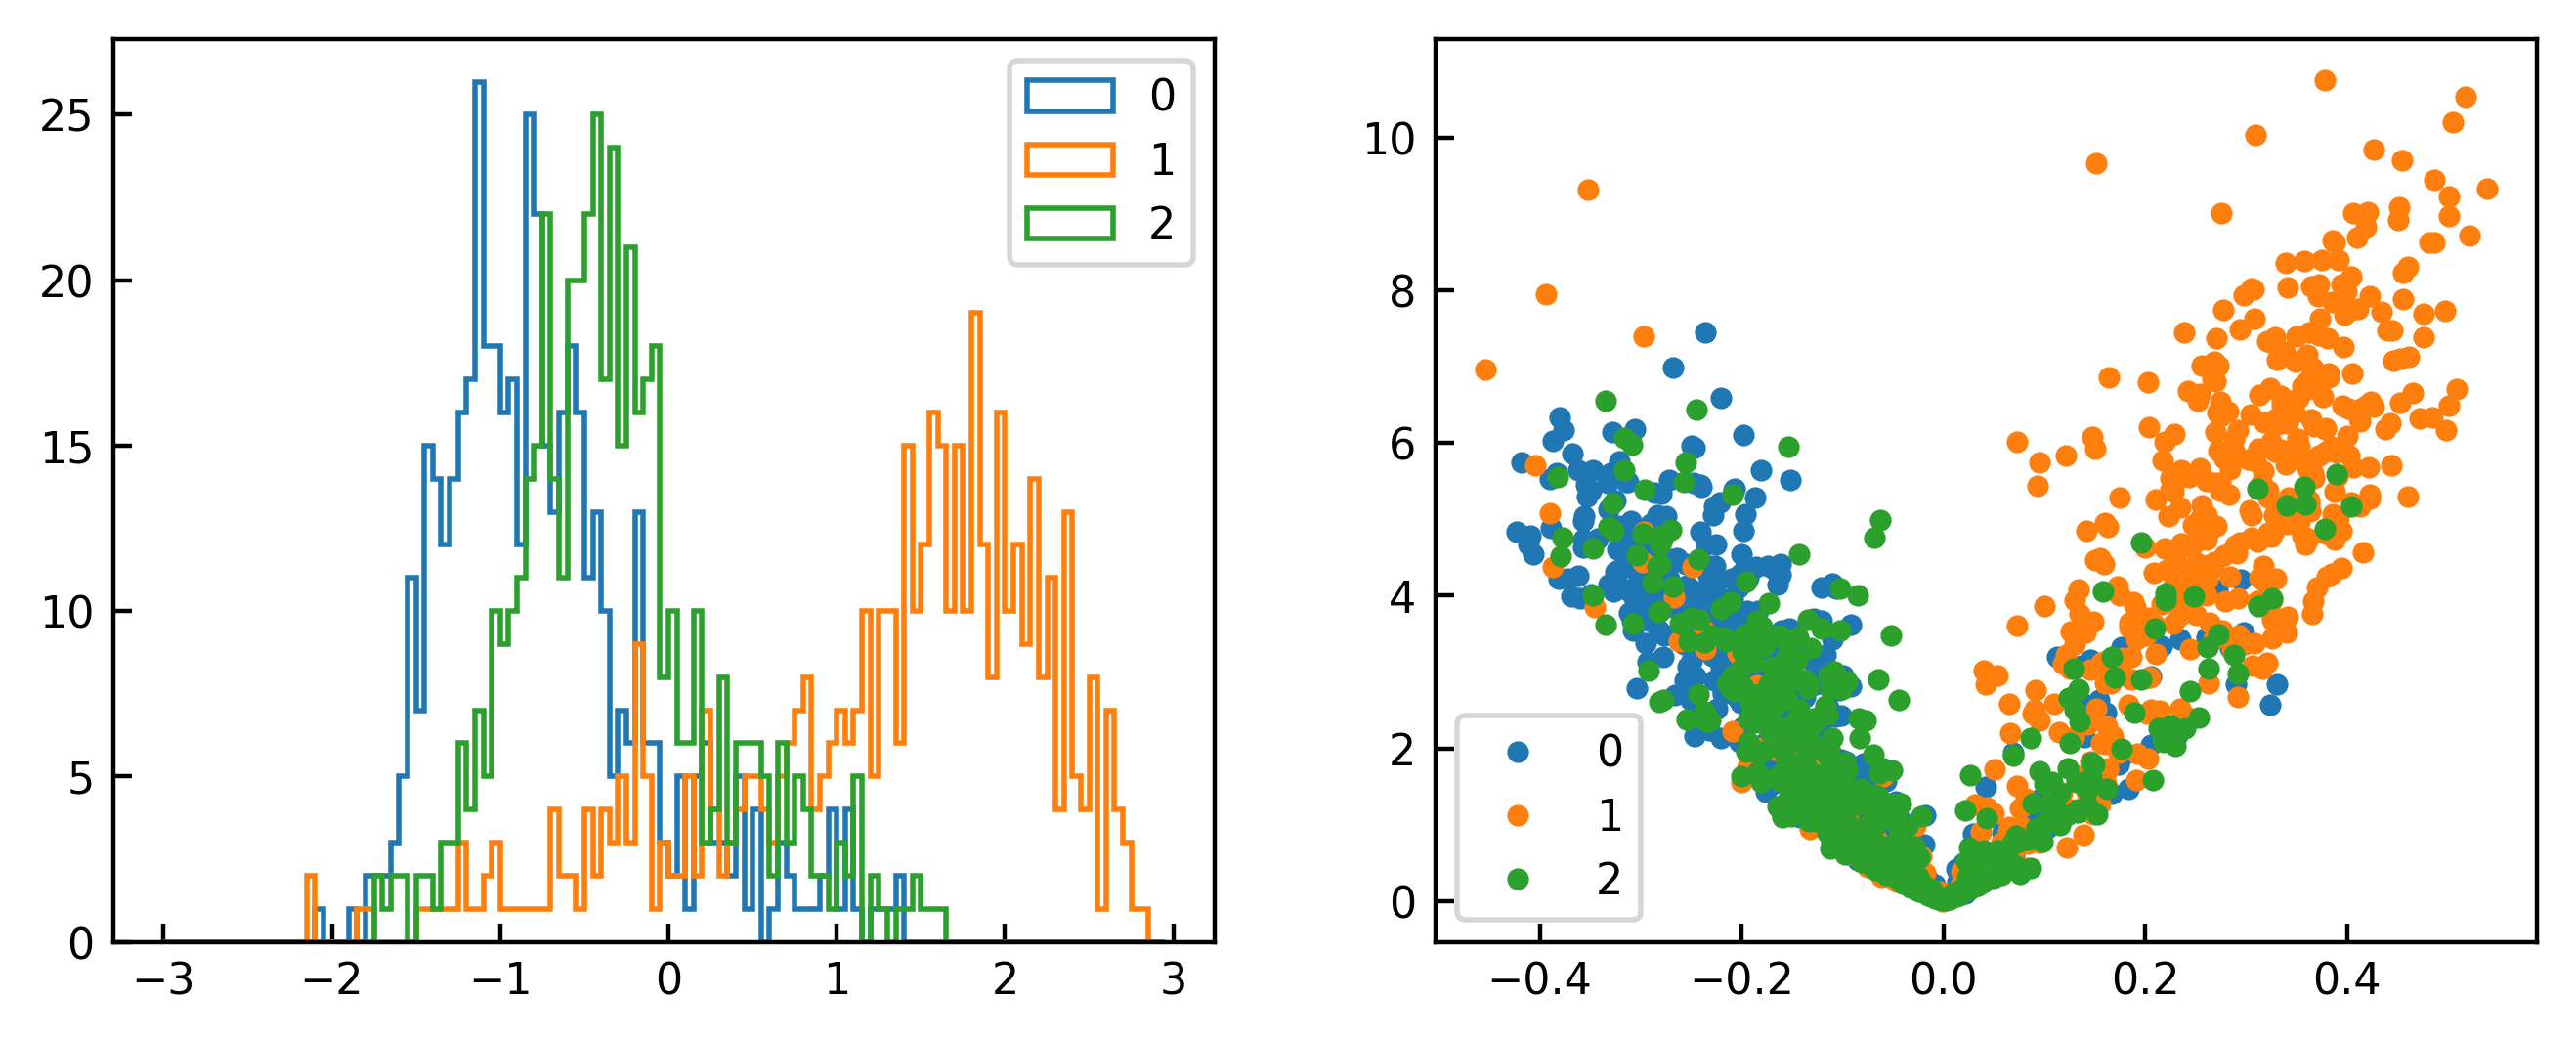

In [38]:
significant_genes = {}

fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=200)

for i in range(n_clusters):
    A = corr_matrix.T.loc[cluster_kmeans==i]
    B = corr_matrix.T.loc[cluster_kmeans!=i]
    d_corr =  A.mean() - B.mean()
    z_corr = (A.mean() - B.mean()) / np.sqrt( A.var() + B.var() )
    
    t_corr, p_corr = sp.stats.ttest_ind(A, B, equal_var=False)
    
    ax[0].hist(z_corr, histtype='step', bins=np.arange(-3, 3, 0.05), label=i)
    ax[1].plot(d_corr, -np.log10(p_corr), '.', label=i)

    p_corr_ = pd.Series(p_corr, index=A.columns).sort_values(key=abs)
    
    cutoff, genes = Benjamini_Hochberg(p_corr_, alpha=0.001)
    
    # significant_genes[i] = p_corr_.loc[p_corr_<1e-2].index.tolist()
    significant_genes[i] = genes[genes].index.tolist()
    # significant_genes[i] = p_corr_[:150].index.tolist()

significant_genes['all'] = corr_matrix.index.sort_values().tolist()
ax[0].legend()
ax[1].legend()

# Save to file
if savefigs:
    with open(significant_genes_file, 'w') as f:
        for key, val in significant_genes.items():
            f.write('>' + str(key) + '\n')
            for gene in val:
                f.write(gene + '\n')
            f.write('\n')

In [39]:
p_corr_[:50].index.tolist()

['TNFRSF4',
 'PRG2',
 'CCR10',
 'COLQ',
 'HSPA6',
 'ASGR1',
 'PTPRCAP',
 'FRK',
 'LTC4S',
 'TREM2',
 'STEAP4',
 'TEP1',
 'CDA',
 'CCL17',
 'LAT',
 'MAP9',
 'EPB41',
 'RAB27B',
 'IL3',
 'LST1',
 'MANEA',
 'GZMM',
 'SLC15A3',
 'DPEP2',
 'PTGIR',
 'LIME1',
 'CEACAM8',
 'GGT5',
 'SMPD3',
 'PLEKHF1',
 'LAG3',
 'CDH12',
 'AIF1',
 'C1orf54',
 'GNLY',
 'CD79B',
 'SOCS1',
 'ASGR2',
 'LY86',
 'CD72',
 'KIR2DS4',
 'MYB',
 'FRMD4A',
 'CCL1',
 'FLT3LG',
 'DACH1',
 'MAP3K13',
 'PDK1',
 'SPAG4',
 'VPREB3']

In [40]:
{k: len(v) for k, v in significant_genes.items()}

{0: 192, 1: 344, 2: 41, 'all': 497}

In [41]:
# I am running the output through gprofiler. Not much has shown up!

In [42]:
Benjamini_Hochberg

<function stat_tools.Benjamini_Hochberg(p, alpha=0.1)>

In [43]:
genes_pathways = []
for key, val in pathways.items():
    genes_pathways.extend(path_name_to_gene[val])
    # print(genes_pathways)


In [44]:
print(len(set(genes_pathways).intersection(immune_genes)))
print(len(genes_pathways))

309
8182


In [45]:
print(len(genes_pathways))

8182


In [46]:
# WARNING: MANY GENES HAVE MULTIPLE ENTIRES IN THE TCGA FILE
# I don't know why

start = time()
df_pathways_vs_sialic = df.loc[df['gene_id'].isin(set(genes_pathways+sialic_genes))]

print(time() - start)
pivot_table2 = pd.pivot_table(
    df_pathways_vs_sialic,
    index='gene_id',
    columns='submitted_specimen_id',
    values='log_tpm_read_count')

print(time() - start)
corr_matrix2 = pivot_table2.T.corr(method='pearson')

print(time() - start)
# I only want the cross correlation terms
corr_matrix2 = \
    corr_matrix2.loc[list(set(genes_pathways).intersection(pivot_table2.index)),
                    list(set(sialic_genes).intersection(pivot_table2.index))]

0.5431079864501953
0.9686391353607178
10.363011837005615


In [47]:
# pathway_genes_dict = { pathway: list(set(path_name_to_gene[val]).intersection(corr_matrix2.index)) 
#                    for pathway, val in pathways.items() }

pathway_genes_dict = { pathway: list(set(path_name_to_gene[val]).intersection(corr_matrix2.index).intersection(immune_genes)) 
                   for pathway, val in pathways.items() }


In [48]:
import heatmap_grouped
reload(heatmap_grouped)
from heatmap_grouped import heatmap_grouped as hg


start = time()
fig = plt.figure(figsize=(10, 8), dpi=600)

dendrogram_colors = ['r',
                     mpl.colors.to_hex('xkcd:green'),
                     mpl.colors.to_hex('xkcd:light green'),
                    ]

hg(corr_matrix2,
   row_dict=pathway_genes_dict,
   column_dict=dict(enumerate(cluster_genes)),
   vmin=-0.6,
   vmax=0.6,
   heatmap_kwargs={'cmap': 'bwr'},
   gridspec_kwargs={'left': 0.28, 'right': 0.9,
                    'top': 0.98, 'bottom': 0.18},
   dendrogram_linkage=sialic_linkage,
   dendrogram_kwargs={'color_threshold': 10,
                      'above_threshold_color': 'k'},

   dendrogram_colors=dendrogram_colors,
   fontsize=12,
   cbar_labelsize=10,
   fig=fig)

if savefigs:
    plt.savefig('figures/correlation_immune_function_vs_siaclic_gene.png', dpi=600)
print(time() - start)

2.422053098678589


# Compare gene expression between matched and tumor

In [49]:
df_select_genes = df.loc[df['gene_id'].isin(sialic_genes)]

df_cancer = df_select_genes[df_select_genes['specimen_type']=='Primary tumour - solid tissue']
df_normal = df_select_genes[df_select_genes['specimen_type']=='Normal - tissue adjacent to primary']

df_ratio = pd.merge(
    df_cancer,
    df_normal,
    on=['submitted_donor_id', 'gene_id'],
    how='inner',
    suffixes=('_cancer','_normal'))

# df_ratio['tpm_ratio'] = df_ratio['tpm_read_count_cancer']/df_ratio['tpm_read_count_normal']
df_ratio['tpm_ratio'] = df_ratio['log_tpm_read_count_cancer'] - df_ratio['log_tpm_read_count_normal']

print(len(df_ratio))

1716


In [50]:
gene_to_cluster = {gene: i for i in range(n_clusters) for gene in cluster_genes[i]}

df_volcano = []
for gene, df_ in df_ratio.groupby('gene_id'):
    t, p = sp.stats.ttest_1samp(df_['tpm_ratio'], 0)
    df_volcano.append({'gene': gene, 't': t, 'p': p, 'log_fc': df_['tpm_ratio'].mean(), 'cluster': gene_to_cluster[gene]})
df_volcano = pd.DataFrame(df_volcano)

p_cutoff, _ = Benjamini_Hochberg(df_volcano['p'], alpha=0.1)
df_volcano['above_threshhold'] = df_volcano['p'] < p_cutoff

df_volcano['cluster'] = df_volcano['cluster'].astype('category')

(-0.6, 0.6)

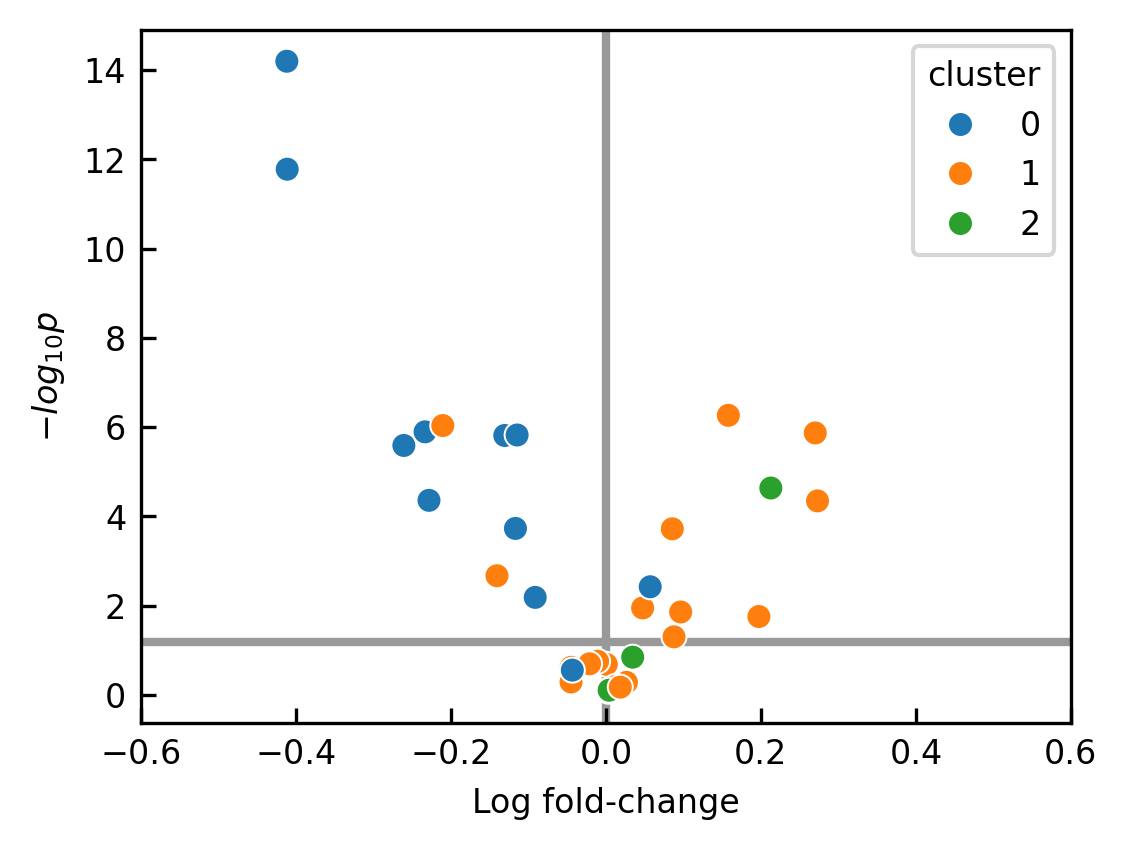

In [51]:
sns.scatterplot(x=df_volcano['log_fc'],
                y=-np.log10(df_volcano['p']),
                hue=df_volcano['cluster'], zorder=2)
plt.axhline(-np.log10(p_cutoff), c='0.6', lw=2, zorder=1)
plt.axvline(0, c='0.6', lw=2, zorder=1)
plt.xlabel('Log fold-change')
plt.ylabel('$-log_{10} p$')
plt.xlim(-0.6, 0.6)

In [52]:
sialic_genes_significant = df_volcano.loc[df_volcano['above_threshhold'], 'gene'].to_list()
print(len(sialic_genes_significant))
cluster_genes_significant = [ [x for x in genes if x in sialic_genes_significant] for genes in cluster_genes ]

21


0.4628582000732422


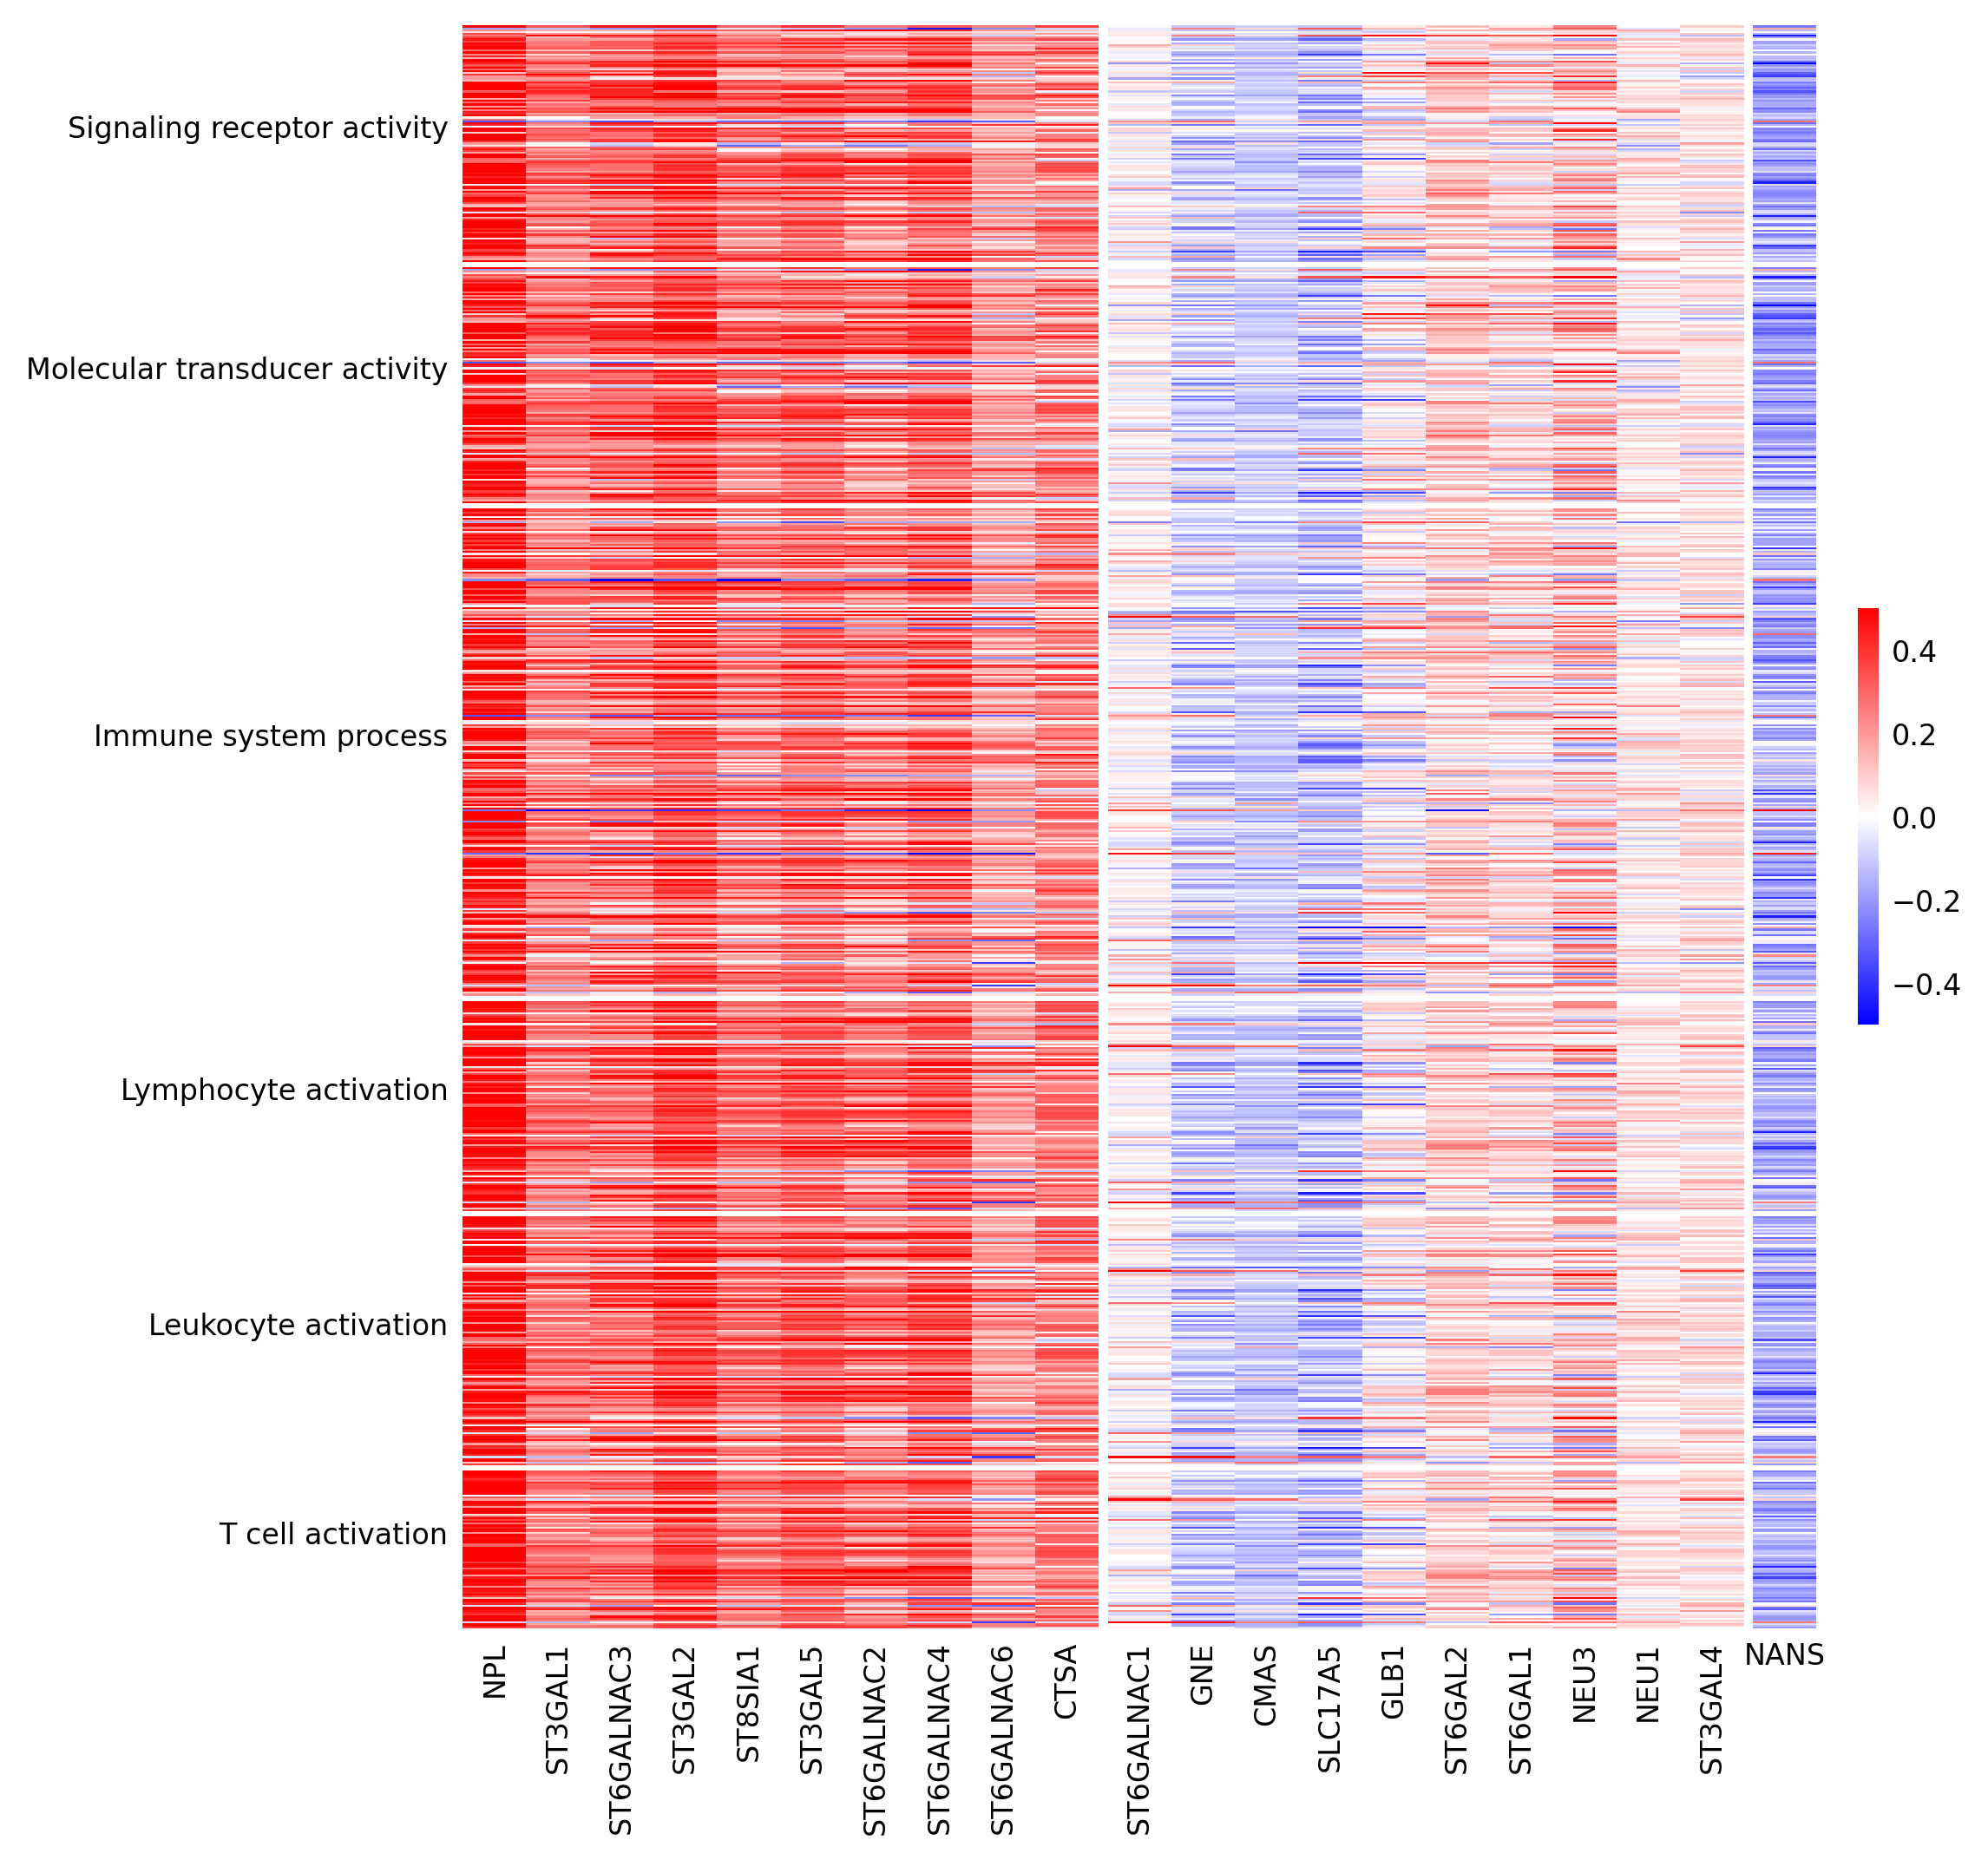

In [53]:
import heatmap_grouped
reload(heatmap_grouped)
from heatmap_grouped import heatmap_grouped as hg


start = time()
fig = plt.figure(figsize=(8, 8), dpi=150)

hg(corr_matrix2,
   row_dict=pathway_genes_dict,
   column_dict=dict(enumerate(cluster_genes_significant)),
   vmin=-0.5,
   vmax=0.5,
   heatmap_kwargs={'cmap': 'bwr'},
   gridspec_kwargs={'left': 0.25, 'right': 0.9},
   fig=fig)

# if savefigs:
#     plt.savefig('figures/correlation_immune_function_vs_siaclic_gene_2.png', dpi=300)
print(time() - start)